In [2]:
!pip install fsspec
!pip install gcsfs
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 7.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 10.4 MB/s 
     |████████████████████████████████| 271 kB 69.4 MB/s 
     |████████████████████████████████| 144 kB 61.9 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 6.8 MB/s 
     |████████████████████████████████| 596 kB 49.1 MB/s 
     |████████████████████████████████| 6.6 MB 56.0 MB/s 
     |████████████████████████████████| 101 kB 15.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/Colab Notebooks/tfm"
import sys
sys.path.append('tfm/checkpoints/')
sys.path.append('tfm/outputs/')

Mounted at /content/drive


In [4]:
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
from transformers import (
    AutoTokenizer,
    TFBertForSequenceClassification,
)

In [5]:
filepath = "../../data/outputs/dataset_2021_paragraph"
filepath = "https://storage.googleapis.com/tfm_aideas_datasets/dataset_2021_paragraph" # Filepath GCloud
filepath = "tfm/outputs/dataset_2021_paragraph" # Filepath COLAB

In [6]:
df_total_labels = pd.read_csv(f"{filepath}_annotated.csv", sep=";", index_col=0, parse_dates=["date"], low_memory=False)

In [7]:
impact_label = df_total_labels.impacto_tag_s_n.isin([0, 1])
dataset_labels = df_total_labels[impact_label]
dataset_unlabelled = df_total_labels[~impact_label]

In [8]:
dataset_opt = Dataset.from_pandas(df_total_labels.loc[~impact_label,["body_no_entities","vola_label"]])

In [9]:
# Para no entrenar varias veces con los mismos párrafos debido a que hayan sido asignados
# a diferentes tickers
dataset_labels.drop_duplicates(subset=["body"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [10]:
dataset_labels.impacto_tag_s_n.value_counts()/sum(dataset_labels.impacto_tag_s_n.value_counts())

1.0    0.779221
0.0    0.220779
Name: impacto_tag_s_n, dtype: float64

A continuación se reentrena únicamente la última capa del modelo BETO para esta tarea de clasificación.

In [11]:
N_LABELS = len(np.unique(dataset_labels.impacto_tag_s_n))

In [12]:
checkpoint = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [13]:
model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels=N_LABELS)

Downloading:   0%|          | 0.00/512M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model.layers[0].trainable=False

In [15]:
model.compile(
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
optimizer=Adam(learning_rate=0.0001),
metrics=['accuracy']
)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(dataset_labels.body_no_entities, dataset_labels.impacto_tag_s_n, test_size=0.2, random_state=42)

In [17]:
x_train = tokenizer(x_train.tolist(), padding="max_length", truncation=True, return_tensors="tf")

In [18]:
x_test = tokenizer(x_test.tolist(), padding="max_length", truncation=True, return_tensors="tf")

In [19]:
N_EPOCAS = 150

In [20]:
# filepath_checkpoint = './checkpoints/impacto_tag_s_n/checkpoint'
filepath_checkpoint = 'tfm/checkpoints/impacto_tag_s_n/checkpoint' # Filepath COLAB

In [21]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=filepath_checkpoint,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')

hist = model.fit(
    dict(x_train),
    y_train,
    batch_size=128,
    epochs=N_EPOCAS,
    validation_split=0.1,
    # callbacks=[model_checkpoint_callback]
    callbacks=[model_checkpoint_callback, early_stopping]
    )

Epoch 1/150
12/12 [==============================] - 61s 4s/step - loss: 0.6393 - accuracy: 0.7076 - val_loss: 0.6122 - val_accuracy: 0.7516
Epoch 2/150
12/12 [==============================] - 41s 3s/step - loss: 0.5828 - accuracy: 0.7806 - val_loss: 0.5793 - val_accuracy: 0.7453
Epoch 3/150
12/12 [==============================] - 41s 3s/step - loss: 0.5477 - accuracy: 0.7826 - val_loss: 0.5646 - val_accuracy: 0.7453
Epoch 4/150
12/12 [==============================] - 41s 3s/step - loss: 0.5303 - accuracy: 0.7826 - val_loss: 0.5575 - val_accuracy: 0.7453
Epoch 5/150
12/12 [==============================] - 41s 3s/step - loss: 0.5244 - accuracy: 0.7826 - val_loss: 0.5523 - val_accuracy: 0.7453
Epoch 6/150
12/12 [==============================] - 41s 3s/step - loss: 0.5174 - accuracy: 0.7826 - val_loss: 0.5468 - val_accuracy: 0.7453
Epoch 7/150
12/12 [==============================] - 41s 3s/step - loss: 0.5128 - accuracy: 0.7826 - val_loss: 0.5405 - val_accuracy: 0.7453
Epoch 8/150
1

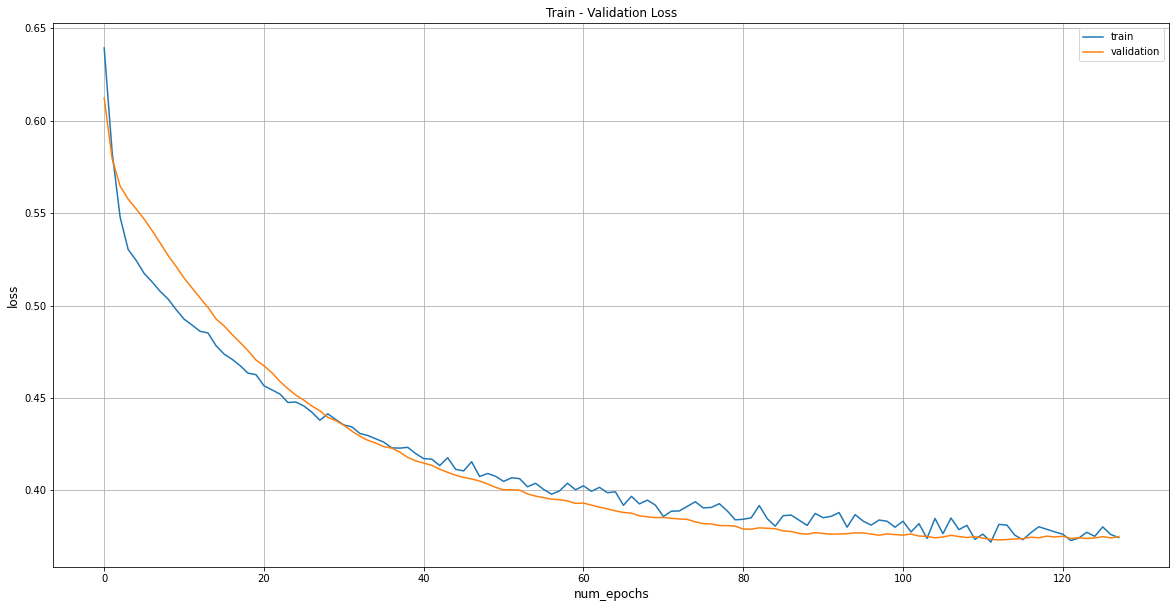

In [22]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

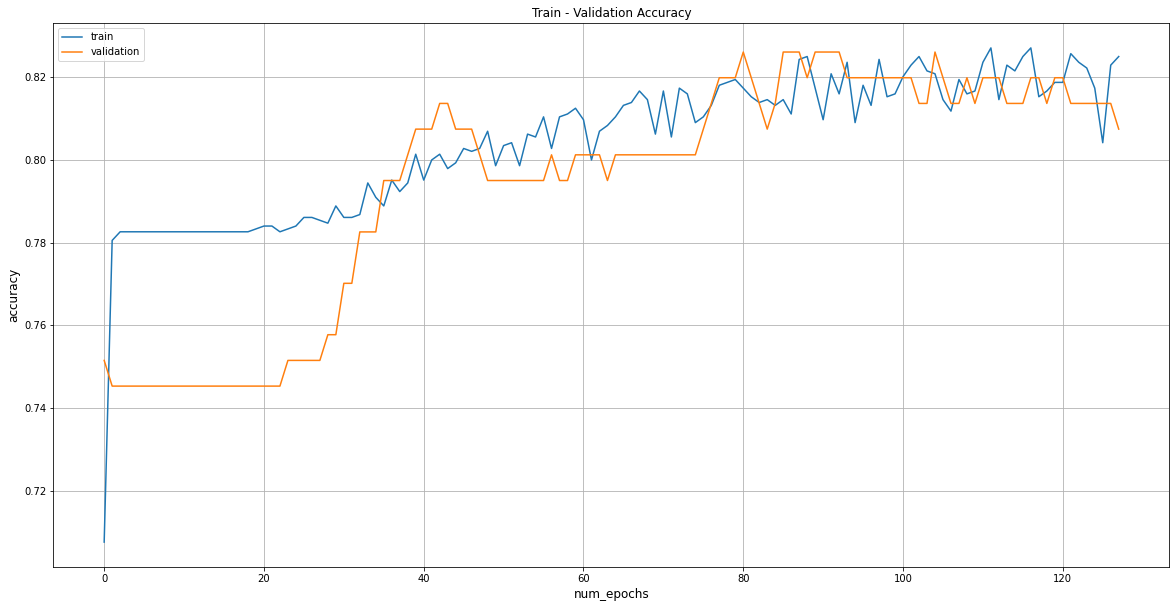

In [23]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

In [24]:
model.load_weights(filepath_checkpoint)
model.evaluate(x_test.data, y_test)

13/13 [==============================] - 9s 712ms/step - loss: 0.3768 - accuracy: 0.8204


[0.37684574723243713, 0.8204488754272461]

In [25]:
# Comparativa con una predicción por clase mayoritaria de train:

pd.Series(y_train).value_counts()/sum(pd.Series(y_train).value_counts())

1.0    0.778888
0.0    0.221112
Name: impacto_tag_s_n, dtype: float64

In [26]:
y_predictions_train = model.predict(x_train.data)

In [27]:
train_posprob = tf.nn.softmax(y_predictions_train.logits).numpy()[:,0]

In [28]:
train_fpr, train_tpr, train_thr = roc_curve(y_train, train_posprob, pos_label=0)

In [29]:
y_predictions_test = model.predict(x_test.data)

In [30]:
test_posprob = tf.nn.softmax(y_predictions_test.logits).numpy()[:,0]

In [31]:
test_fpr, test_tpr, test_thr = roc_curve(y_test, test_posprob, pos_label=0)

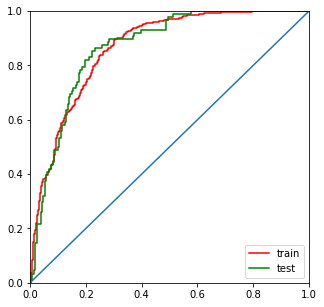

In [32]:
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(train_fpr, train_tpr, color='r', label='train')
plt.plot(test_fpr, test_tpr, color='g', label='test')

plt.plot([0,1],[0,1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.0])
plt.legend(loc='lower right')
plt.show()

In [33]:
y_pred = y_predictions_test.logits.argmax(axis=1)

In [34]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.66      0.38      0.48        88
         1.0       0.84      0.95      0.89       313

    accuracy                           0.82       401
   macro avg       0.75      0.66      0.68       401
weighted avg       0.80      0.82      0.80       401



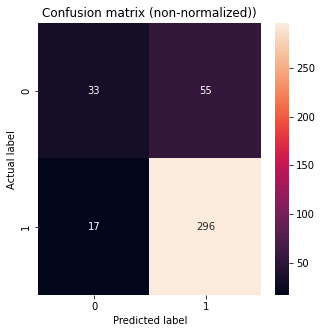

In [35]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_test, y_pred)

In [36]:
def encode(input):
    return tokenizer(input["body_no_entities"], padding="max_length", truncation=True)

In [37]:
tokenized_dataset = dataset_opt.map(encode, batched=True)
tf_tokenized_dataset = tokenized_dataset.remove_columns(["pk", "body_no_entities",  "vola_label"])
tf_tokenized_dataset.set_format(type='tensorflow', columns=['input_ids', 'token_type_ids', 'attention_mask'])

Parameter 'function'=<function encode at 0x7f46a2a6c5f0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/495 [00:00<?, ?ba/s]

In [38]:
results = model.predict(tf_tokenized_dataset.to_tf_dataset(batch_size=256), verbose=1)

1932/1932 [==============================] - 11001s 6s/step


In [39]:
df_total_labels["impacto_tag_s_proba"] = np.NaN
df_total_labels.loc[impact_label, "impacto_tag_s_proba"] = df_total_labels.loc[impact_label, "impacto_tag_s_n"].replace({0.0:2.0}).replace({1.0:0.0}).replace({2.0:1.0})
df_total_labels["impacto_tag_s_n_confianza"] = np.NaN
df_total_labels.loc[impact_label, "impacto_tag_s_n_confianza"] = 1.
df_total_labels.loc[~impact_label, 'impacto_tag_s_n'] = results.logits.argmax(axis=1)
df_total_labels.loc[~impact_label, 'impacto_tag_s_proba'] = tf.nn.softmax(results.logits).numpy()[:,0]
df_total_labels.loc[~impact_label, 'impacto_tag_s_n_confianza'] = tf.nn.softmax(results.logits).numpy().max(axis=1)

In [ ]:
df_total_labels.to_csv(f'{filepath}_predict_impacto_tag_s_n.csv', sep=";")

# Transfer Learning con BETO con KFold

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 1...
Epoch 1/100
51/51 [==============================] - 63s 1s/step - loss: 0.6030 - accuracy: 0.7309 - val_loss: 0.5113 - val_accuracy: 0.8232
Epoch 2/100
51/51 [==============================] - 47s 923ms/step - loss: 0.5349 - accuracy: 0.7772 - val_loss: 0.4789 - val_accuracy: 0.8232
Epoch 3/100
51/51 [==============================] - 47s 920ms/step - loss: 0.5162 - accuracy: 0.7765 - val_loss: 0.4627 - val_accuracy: 0.8232
Epoch 4/100
51/51 [==============================] - 47s 921ms/step - loss: 0.5006 - accuracy: 0.7772 - val_loss: 0.4498 - val_accuracy: 0.8232
Epoch 5/100
51/51 [==============================] - 47s 921ms/step - loss: 0.4879 - accuracy: 0.7772 - val_loss: 0.4377 - val_accuracy: 0.8232
Epoch 6/100
51/51 [==============================] - 47s 922ms/step - loss: 0.4765 - accuracy: 0.7772 - val_loss: 0.4321 - val_accuracy: 0.8232
Epoch 7/100
51/51 [==============================] - 47s 921ms/step - loss: 0.4649 - accuracy: 0.7790 - val_loss: 0

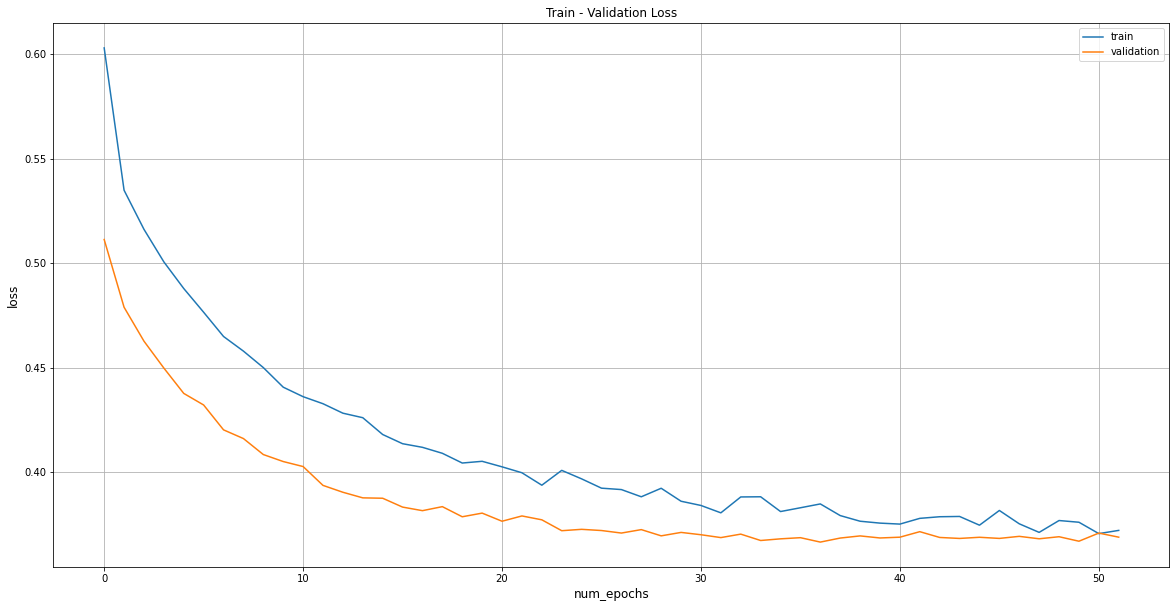

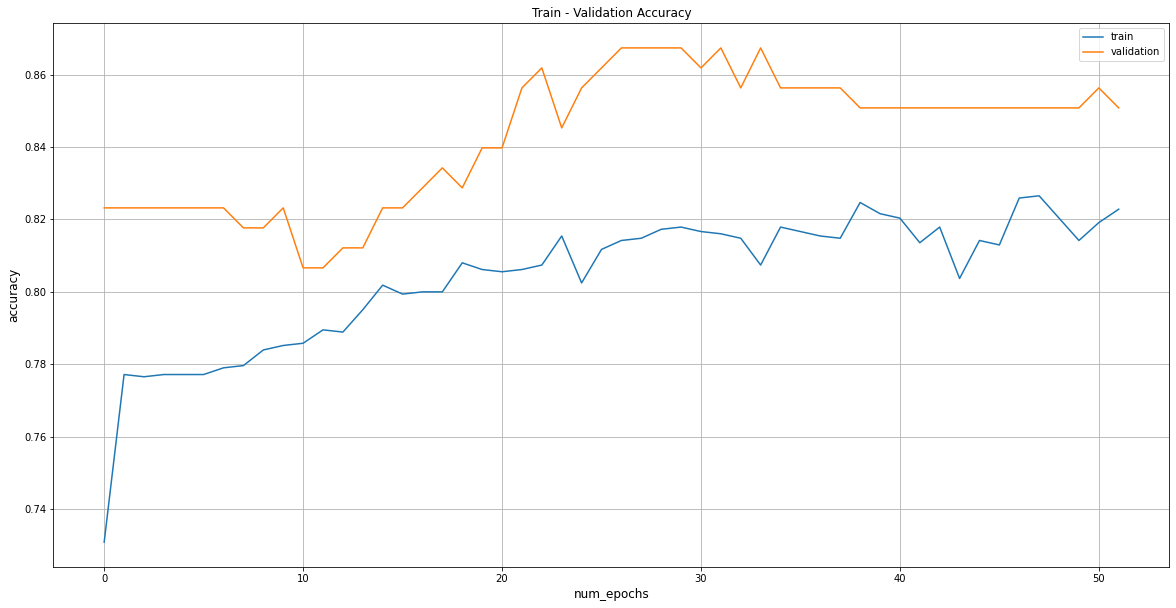

7/7 [==============================] - 5s 656ms/step - loss: 0.4054 - accuracy: 0.7960
Accuracy: 0.7960199117660522


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 2...
Epoch 1/100
51/51 [==============================] - 64s 1s/step - loss: 0.5858 - accuracy: 0.7537 - val_loss: 0.4748 - val_accuracy: 0.8398
Epoch 2/100
51/51 [==============================] - 47s 922ms/step - loss: 0.5301 - accuracy: 0.7747 - val_loss: 0.4514 - val_accuracy: 0.8398
Epoch 3/100
51/51 [==============================] - 47s 922ms/step - loss: 0.5106 - accuracy: 0.7747 - val_loss: 0.4410 - val_accuracy: 0.8398
Epoch 4/100
51/51 [==============================] - 47s 921ms/step - loss: 0.4975 - accuracy: 0.7747 - val_loss: 0.4301 - val_accuracy: 0.8398
Epoch 5/100
51/51 [==============================] - 47s 921ms/step - loss: 0.4849 - accuracy: 0.7747 - val_loss: 0.4211 - val_accuracy: 0.8398
Epoch 6/100
51/51 [==============================] - 47s 920ms/step - loss: 0.4731 - accuracy: 0.7753 - val_loss: 0.4125 - val_accuracy: 0.8343
Epoch 7/100
51/51 [==============================] - 47s 922ms/step - loss: 0.4648 - accuracy: 0.7747 - val_loss: 0

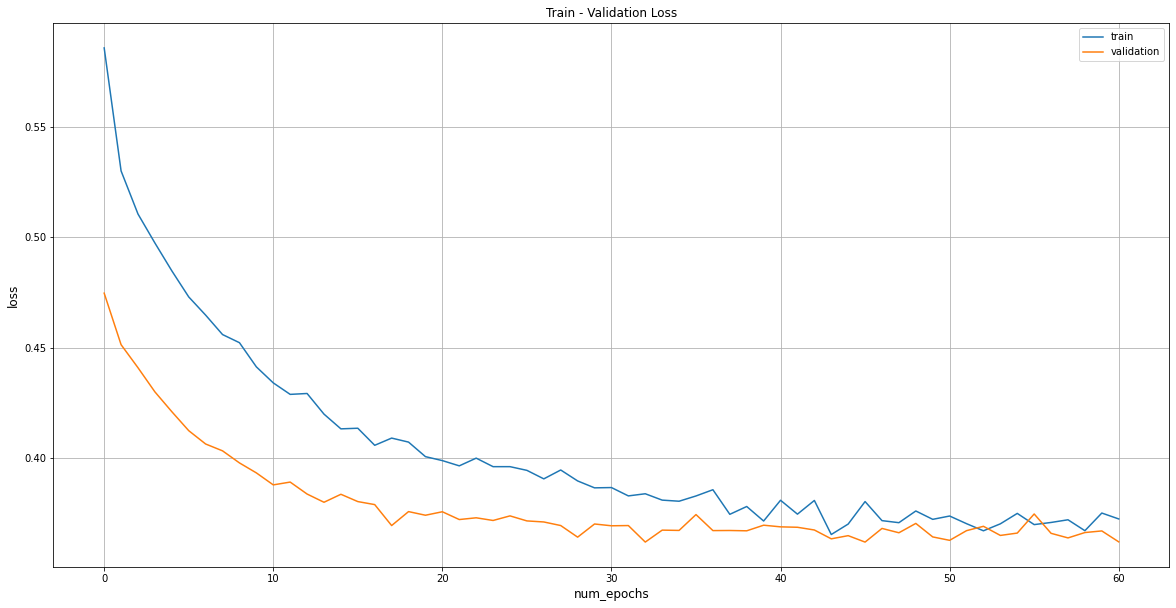

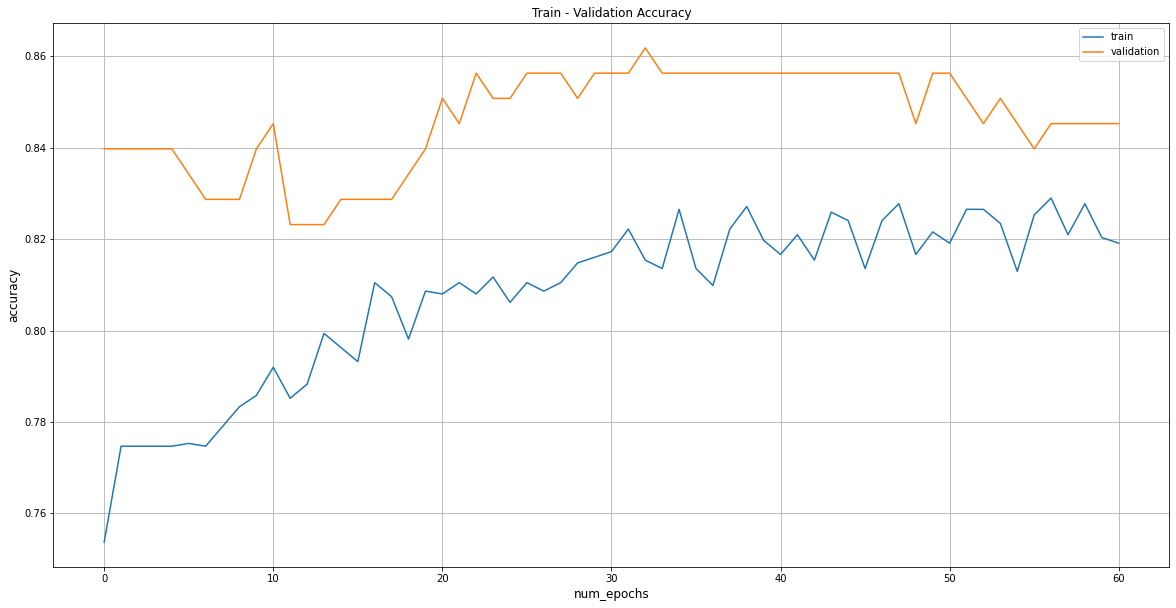

7/7 [==============================] - 5s 658ms/step - loss: 0.4245 - accuracy: 0.7711
Accuracy: 0.7711442708969116


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 3...
Epoch 1/100
51/51 [==============================] - 63s 1s/step - loss: 0.6436 - accuracy: 0.6527 - val_loss: 0.4760 - val_accuracy: 0.8674
Epoch 2/100
51/51 [==============================] - 47s 924ms/step - loss: 0.5434 - accuracy: 0.7785 - val_loss: 0.4187 - val_accuracy: 0.8674
Epoch 3/100
51/51 [==============================] - 47s 923ms/step - loss: 0.5216 - accuracy: 0.7785 - val_loss: 0.4039 - val_accuracy: 0.8674
Epoch 4/100
51/51 [==============================] - 47s 924ms/step - loss: 0.5032 - accuracy: 0.7785 - val_loss: 0.3898 - val_accuracy: 0.8674
Epoch 5/100
51/51 [==============================] - 47s 923ms/step - loss: 0.4848 - accuracy: 0.7785 - val_loss: 0.3820 - val_accuracy: 0.8674
Epoch 6/100
51/51 [==============================] - 47s 923ms/step - loss: 0.4735 - accuracy: 0.7785 - val_loss: 0.3778 - val_accuracy: 0.8619
Epoch 7/100
51/51 [==============================] - 47s 923ms/step - loss: 0.4648 - accuracy: 0.7810 - val_loss: 0

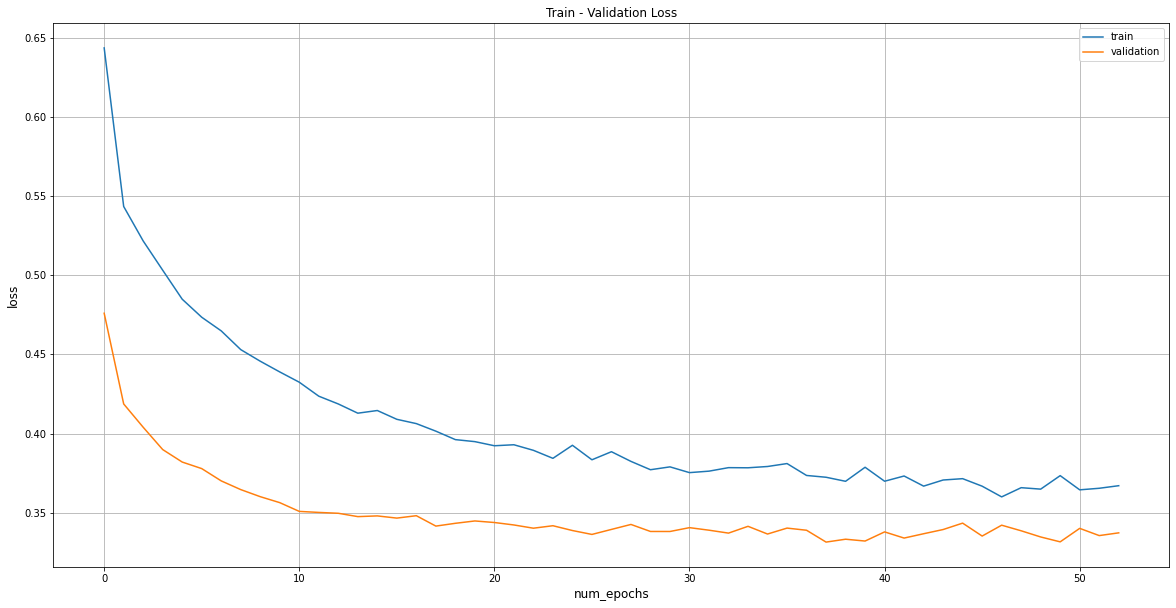

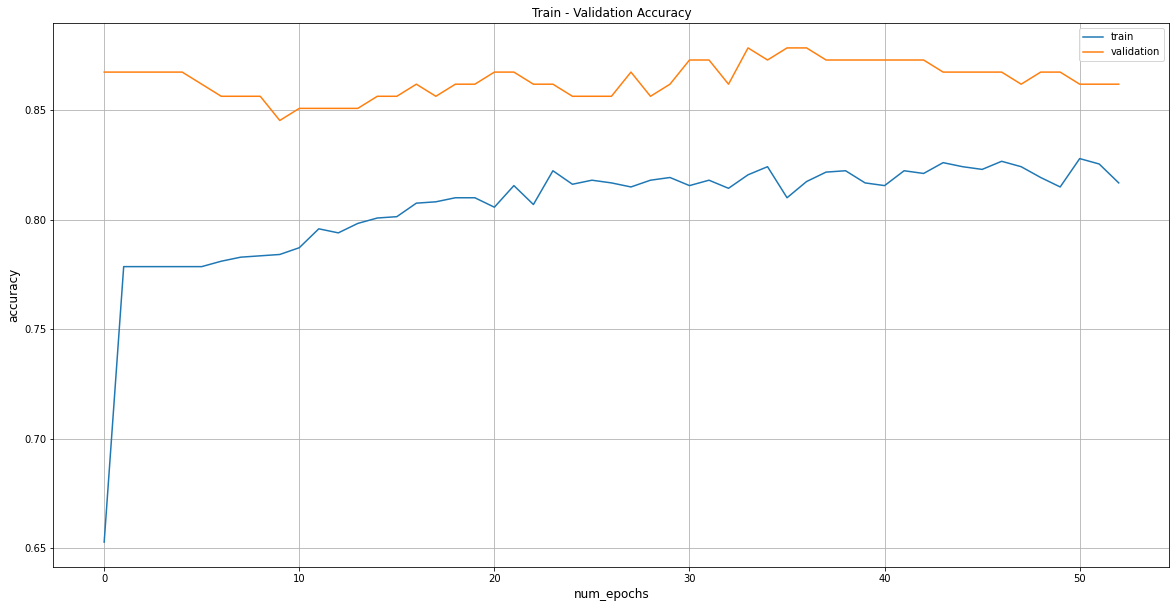

7/7 [==============================] - 5s 656ms/step - loss: 0.4292 - accuracy: 0.8050
Accuracy: 0.8050000071525574


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 4...
Epoch 1/100
51/51 [==============================] - 65s 1s/step - loss: 0.5899 - accuracy: 0.7514 - val_loss: 0.4737 - val_accuracy: 0.8398
Epoch 2/100
51/51 [==============================] - 47s 927ms/step - loss: 0.5342 - accuracy: 0.7736 - val_loss: 0.4474 - val_accuracy: 0.8398
Epoch 3/100
51/51 [==============================] - 47s 925ms/step - loss: 0.5156 - accuracy: 0.7736 - val_loss: 0.4318 - val_accuracy: 0.8398
Epoch 4/100
51/51 [==============================] - 49s 960ms/step - loss: 0.5014 - accuracy: 0.7736 - val_loss: 0.4206 - val_accuracy: 0.8453
Epoch 5/100
51/51 [==============================] - 47s 925ms/step - loss: 0.4865 - accuracy: 0.7736 - val_loss: 0.4108 - val_accuracy: 0.8453
Epoch 6/100
51/51 [==============================] - 47s 925ms/step - loss: 0.4733 - accuracy: 0.7748 - val_loss: 0.4018 - val_accuracy: 0.8398
Epoch 7/100
51/51 [==============================] - 47s 925ms/step - loss: 0.4649 - accuracy: 0.7754 - val_loss: 0

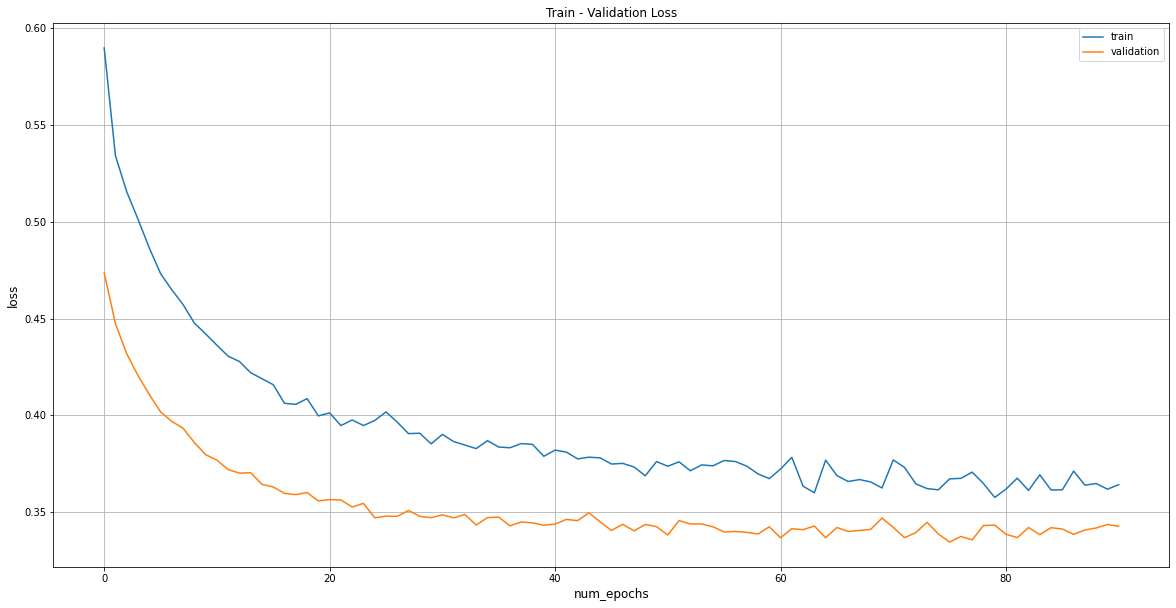

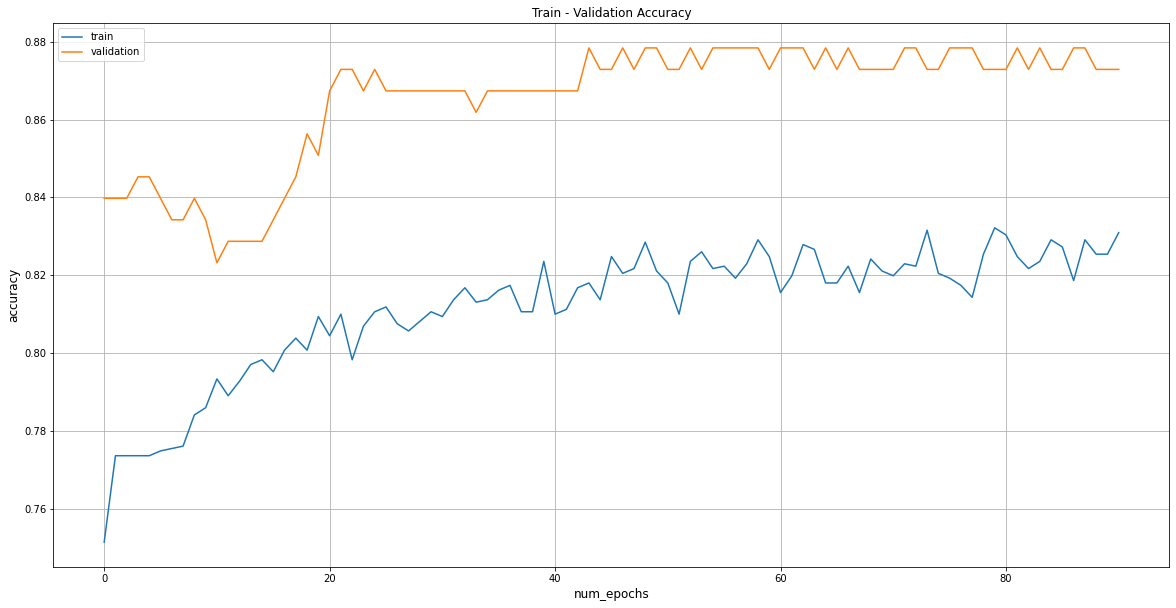

7/7 [==============================] - 5s 656ms/step - loss: 0.3778 - accuracy: 0.8200
Accuracy: 0.8199999928474426


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 5...
Epoch 1/100
51/51 [==============================] - 64s 1s/step - loss: 0.5715 - accuracy: 0.7693 - val_loss: 0.4532 - val_accuracy: 0.8508
Epoch 2/100
51/51 [==============================] - 47s 926ms/step - loss: 0.5226 - accuracy: 0.7717 - val_loss: 0.4281 - val_accuracy: 0.8508
Epoch 3/100
51/51 [==============================] - 47s 926ms/step - loss: 0.5061 - accuracy: 0.7711 - val_loss: 0.4199 - val_accuracy: 0.8453
Epoch 4/100
51/51 [==============================] - 47s 925ms/step - loss: 0.4903 - accuracy: 0.7730 - val_loss: 0.4081 - val_accuracy: 0.8398
Epoch 5/100
51/51 [==============================] - 47s 924ms/step - loss: 0.4770 - accuracy: 0.7754 - val_loss: 0.4034 - val_accuracy: 0.8343
Epoch 6/100
51/51 [==============================] - 47s 925ms/step - loss: 0.4657 - accuracy: 0.7798 - val_loss: 0.4016 - val_accuracy: 0.8287
Epoch 7/100
51/51 [==============================] - 47s 925ms/step - loss: 0.4585 - accuracy: 0.7853 - val_loss: 0

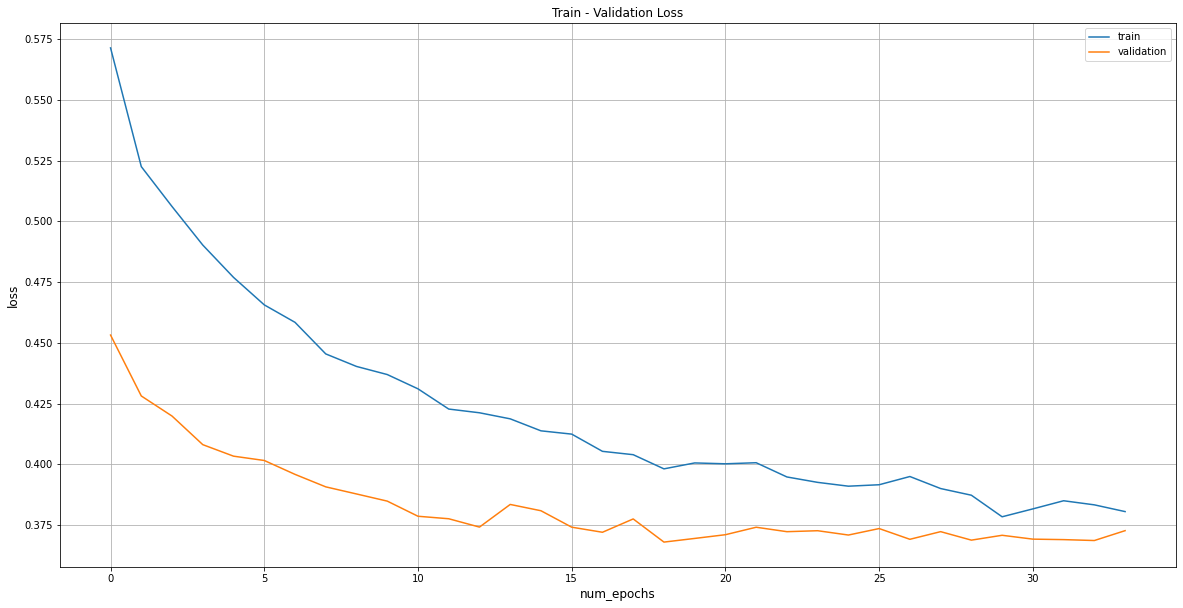

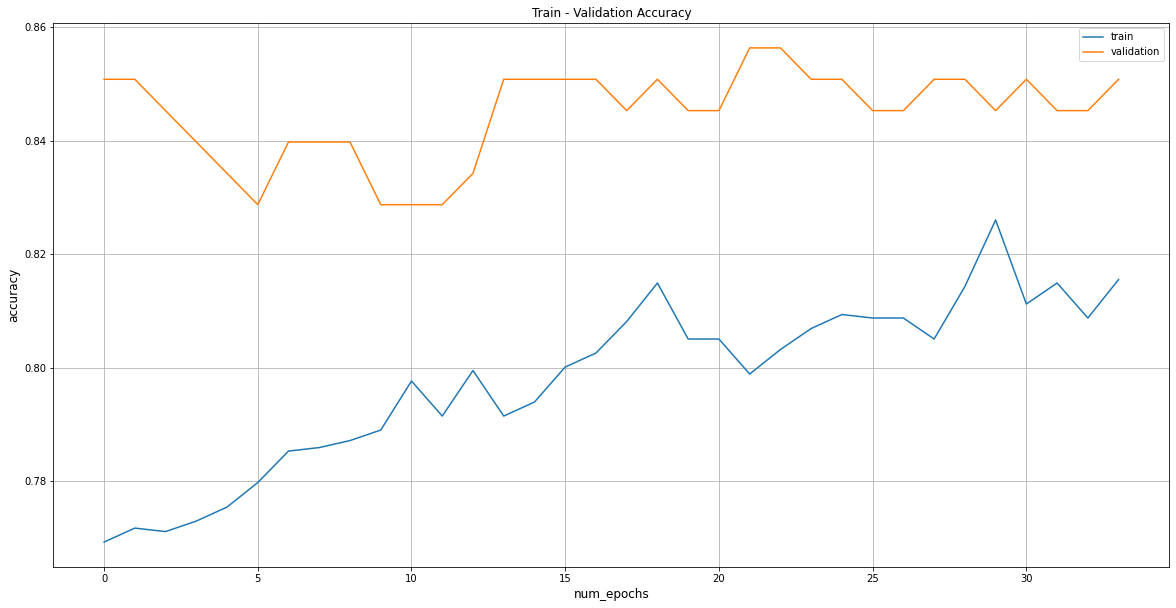

7/7 [==============================] - 5s 657ms/step - loss: 0.4067 - accuracy: 0.8150
Accuracy: 0.8149999976158142


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 6...
Epoch 1/100
51/51 [==============================] - 64s 1s/step - loss: 0.6130 - accuracy: 0.7094 - val_loss: 0.4930 - val_accuracy: 0.8453
Epoch 2/100
51/51 [==============================] - 47s 926ms/step - loss: 0.5328 - accuracy: 0.7705 - val_loss: 0.4542 - val_accuracy: 0.8453
Epoch 3/100
51/51 [==============================] - 47s 926ms/step - loss: 0.5174 - accuracy: 0.7705 - val_loss: 0.4406 - val_accuracy: 0.8453
Epoch 4/100
51/51 [==============================] - 47s 925ms/step - loss: 0.4999 - accuracy: 0.7705 - val_loss: 0.4309 - val_accuracy: 0.8453
Epoch 5/100
51/51 [==============================] - 47s 926ms/step - loss: 0.4881 - accuracy: 0.7705 - val_loss: 0.4249 - val_accuracy: 0.8453
Epoch 6/100
51/51 [==============================] - 47s 926ms/step - loss: 0.4749 - accuracy: 0.7730 - val_loss: 0.4129 - val_accuracy: 0.8343
Epoch 7/100
51/51 [==============================] - 47s 925ms/step - loss: 0.4661 - accuracy: 0.7767 - val_loss: 0

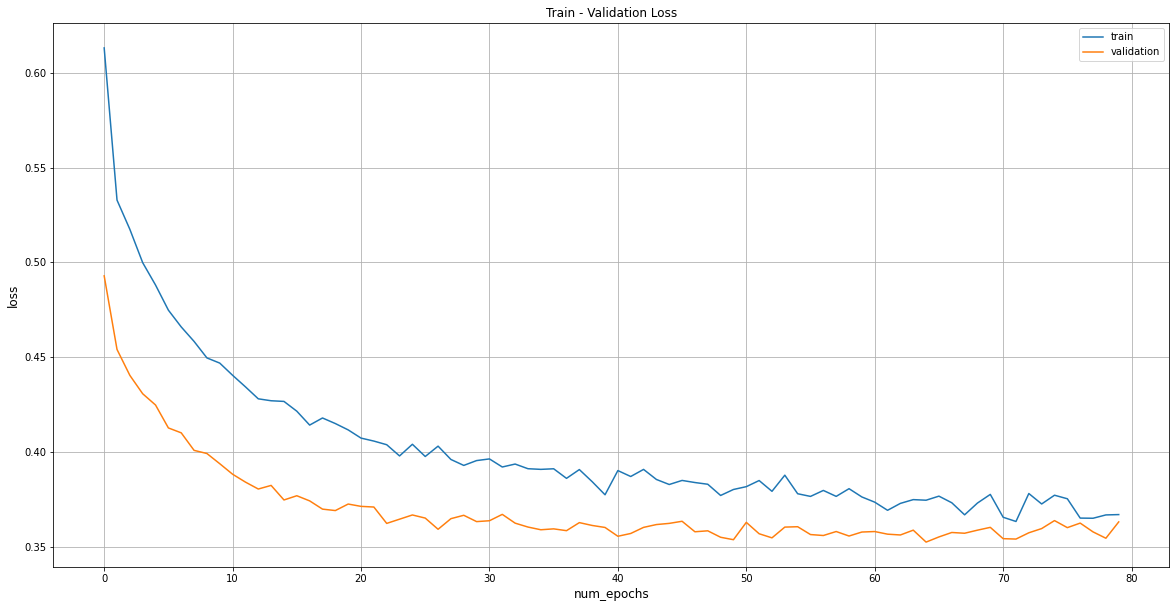

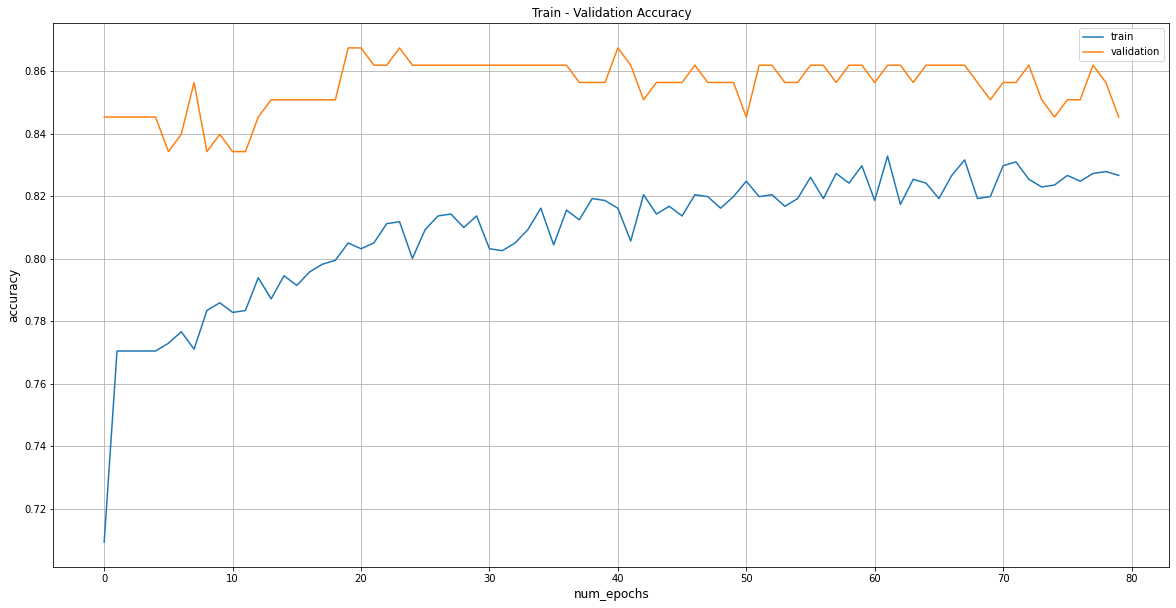

7/7 [==============================] - 5s 659ms/step - loss: 0.3701 - accuracy: 0.8100
Accuracy: 0.8100000023841858


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 7...
Epoch 1/100
51/51 [==============================] - 64s 1s/step - loss: 0.5848 - accuracy: 0.7594 - val_loss: 0.4530 - val_accuracy: 0.8508
Epoch 2/100
51/51 [==============================] - 47s 929ms/step - loss: 0.5341 - accuracy: 0.7705 - val_loss: 0.4265 - val_accuracy: 0.8508
Epoch 3/100
51/51 [==============================] - 47s 928ms/step - loss: 0.5117 - accuracy: 0.7705 - val_loss: 0.4127 - val_accuracy: 0.8508
Epoch 4/100
51/51 [==============================] - 47s 927ms/step - loss: 0.4944 - accuracy: 0.7717 - val_loss: 0.3995 - val_accuracy: 0.8508
Epoch 5/100
51/51 [==============================] - 47s 927ms/step - loss: 0.4767 - accuracy: 0.7705 - val_loss: 0.3898 - val_accuracy: 0.8508
Epoch 6/100
51/51 [==============================] - 47s 927ms/step - loss: 0.4650 - accuracy: 0.7736 - val_loss: 0.3825 - val_accuracy: 0.8453
Epoch 7/100
51/51 [==============================] - 47s 927ms/step - loss: 0.4549 - accuracy: 0.7791 - val_loss: 0

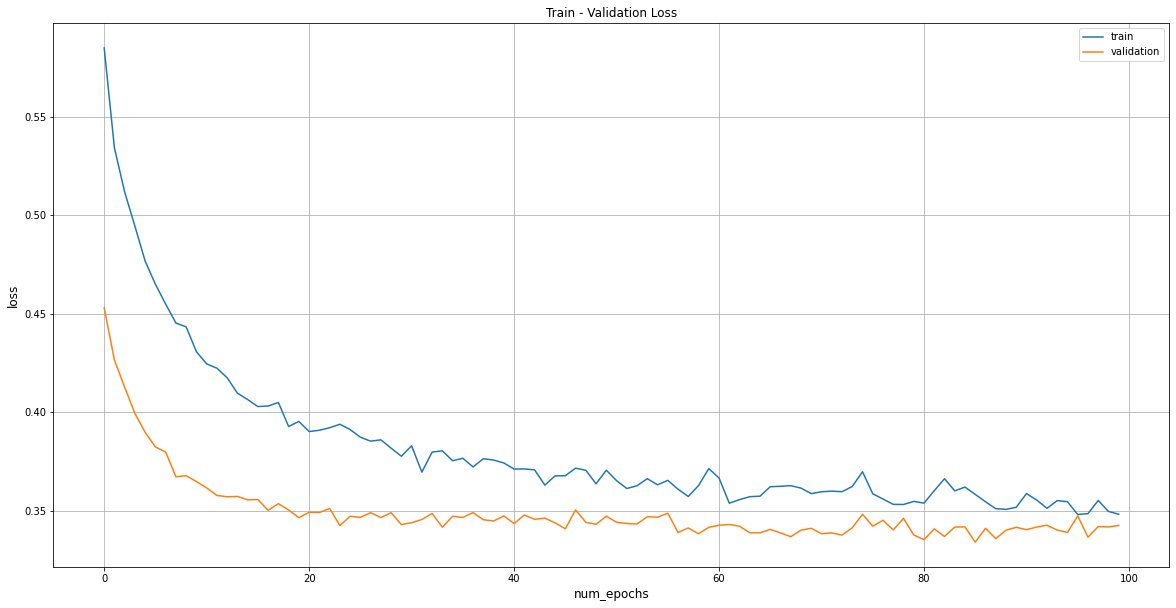

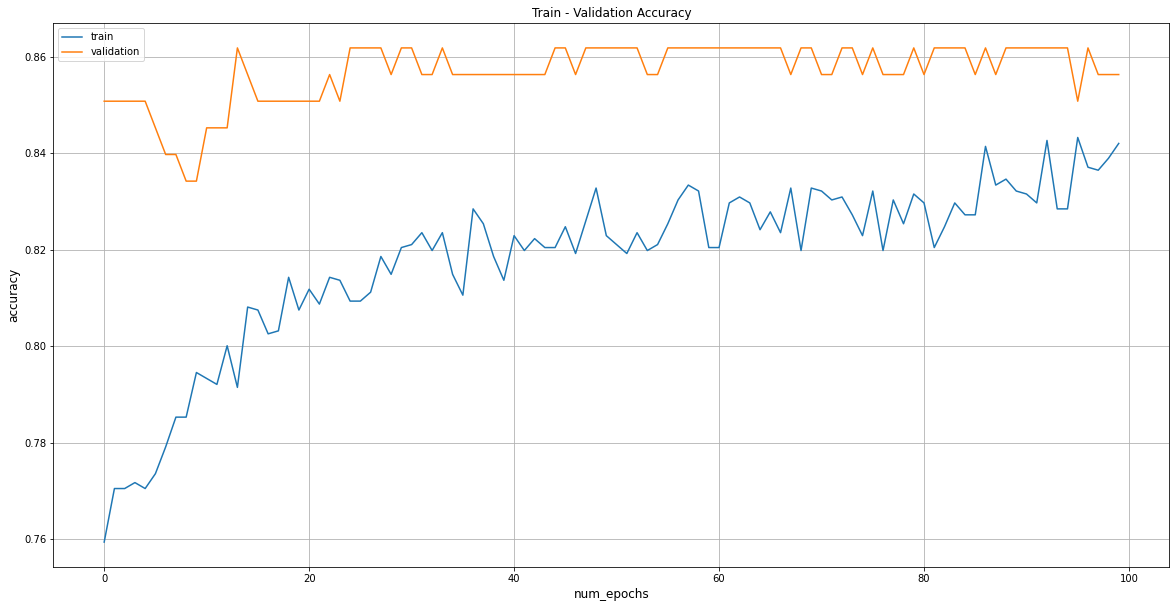

7/7 [==============================] - 5s 656ms/step - loss: 0.4295 - accuracy: 0.7900
Accuracy: 0.7900000214576721


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 8...
Epoch 1/100
51/51 [==============================] - 63s 1s/step - loss: 0.6329 - accuracy: 0.6607 - val_loss: 0.4823 - val_accuracy: 0.8619
Epoch 2/100
51/51 [==============================] - 47s 926ms/step - loss: 0.5410 - accuracy: 0.7643 - val_loss: 0.4324 - val_accuracy: 0.8619
Epoch 3/100
51/51 [==============================] - 47s 924ms/step - loss: 0.5208 - accuracy: 0.7643 - val_loss: 0.4192 - val_accuracy: 0.8619
Epoch 4/100
51/51 [==============================] - 47s 925ms/step - loss: 0.5066 - accuracy: 0.7643 - val_loss: 0.4128 - val_accuracy: 0.8619
Epoch 5/100
51/51 [==============================] - 47s 924ms/step - loss: 0.4936 - accuracy: 0.7643 - val_loss: 0.4030 - val_accuracy: 0.8564
Epoch 6/100
51/51 [==============================] - 47s 924ms/step - loss: 0.4792 - accuracy: 0.7650 - val_loss: 0.4006 - val_accuracy: 0.8564
Epoch 7/100
51/51 [==============================] - 47s 924ms/step - loss: 0.4691 - accuracy: 0.7717 - val_loss: 0

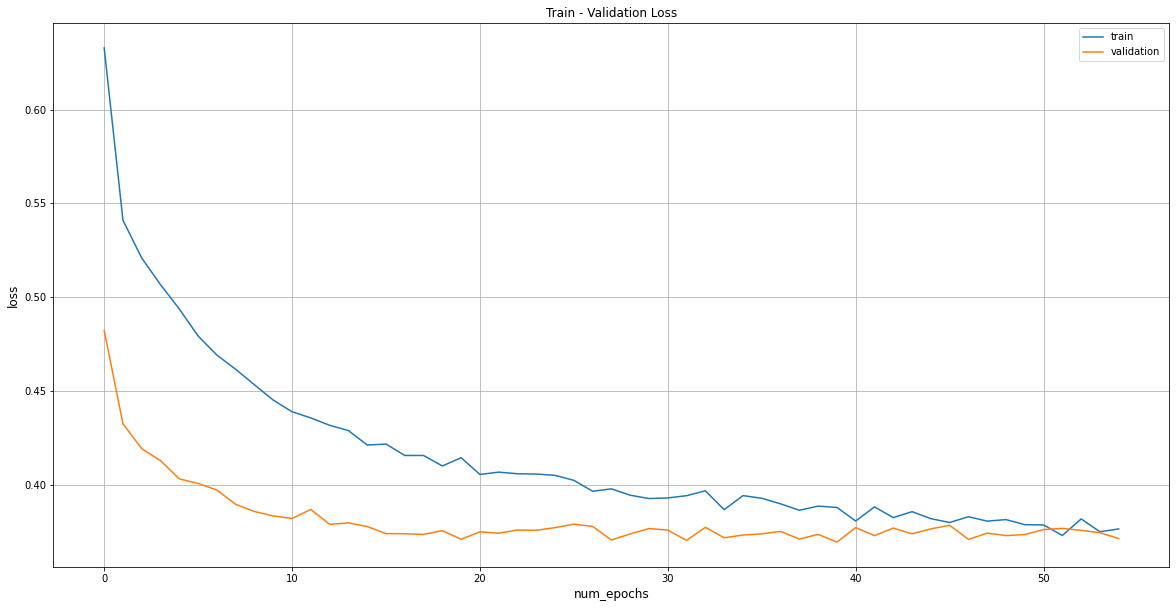

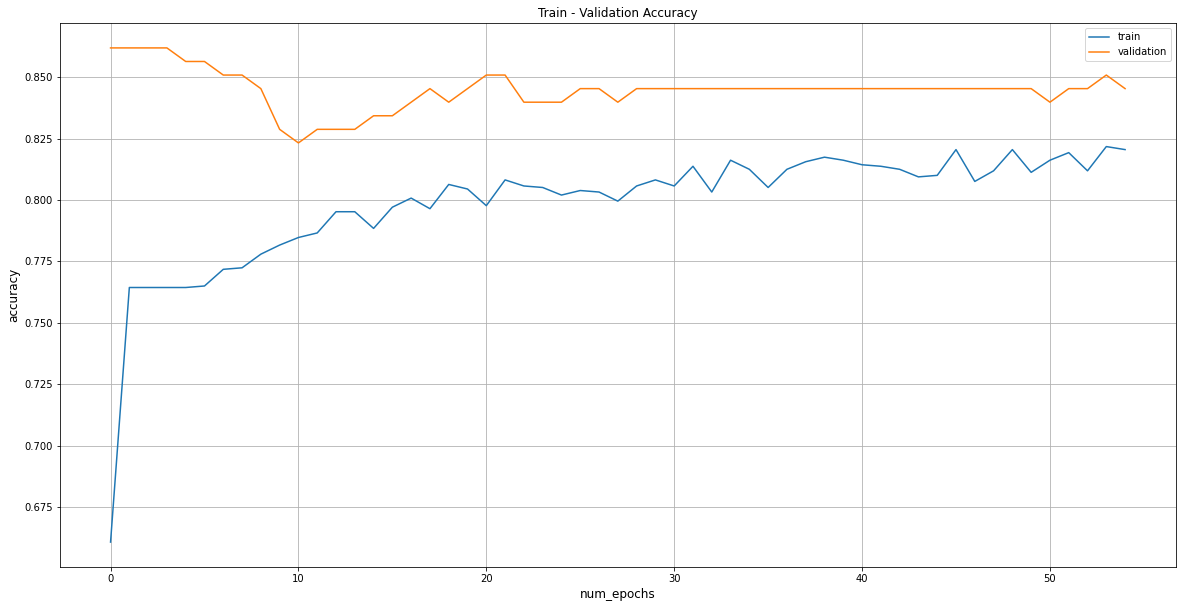

7/7 [==============================] - 5s 657ms/step - loss: 0.5194 - accuracy: 0.8250
Accuracy: 0.824999988079071


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 9...
Epoch 1/100
51/51 [==============================] - 64s 1s/step - loss: 0.6055 - accuracy: 0.7323 - val_loss: 0.4876 - val_accuracy: 0.8453
Epoch 2/100
51/51 [==============================] - 47s 927ms/step - loss: 0.5465 - accuracy: 0.7656 - val_loss: 0.4579 - val_accuracy: 0.8453
Epoch 3/100
51/51 [==============================] - 47s 925ms/step - loss: 0.5285 - accuracy: 0.7656 - val_loss: 0.4459 - val_accuracy: 0.8453
Epoch 4/100
51/51 [==============================] - 47s 924ms/step - loss: 0.5128 - accuracy: 0.7656 - val_loss: 0.4294 - val_accuracy: 0.8453
Epoch 5/100
51/51 [==============================] - 47s 925ms/step - loss: 0.4952 - accuracy: 0.7662 - val_loss: 0.4239 - val_accuracy: 0.8453
Epoch 6/100
51/51 [==============================] - 47s 925ms/step - loss: 0.4810 - accuracy: 0.7662 - val_loss: 0.4105 - val_accuracy: 0.8453
Epoch 7/100
51/51 [==============================] - 47s 925ms/step - loss: 0.4698 - accuracy: 0.7668 - val_loss: 0

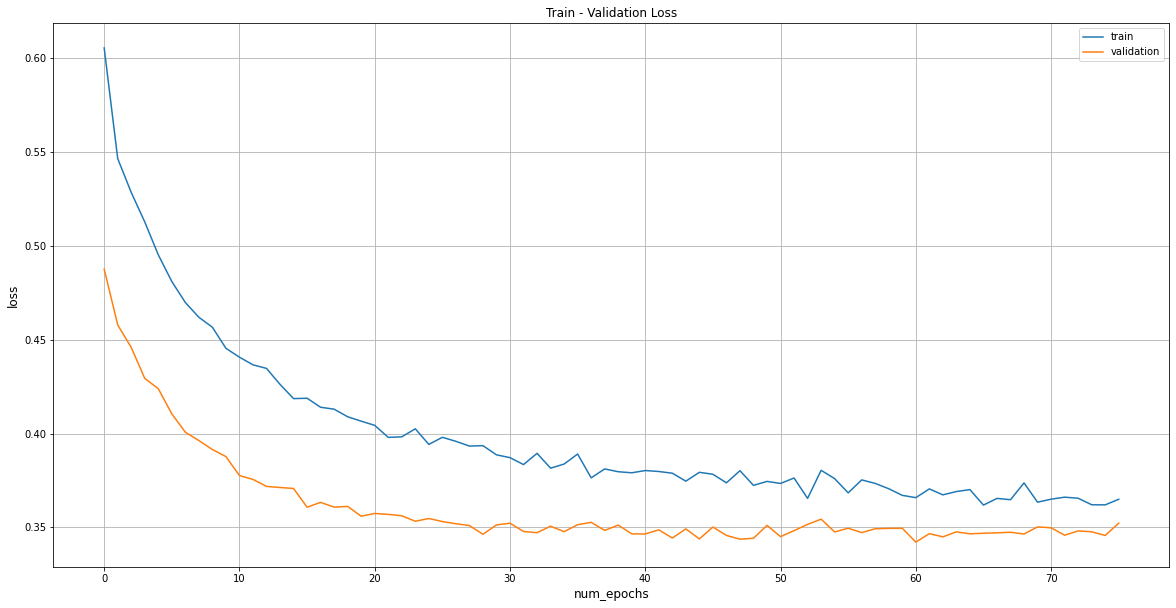

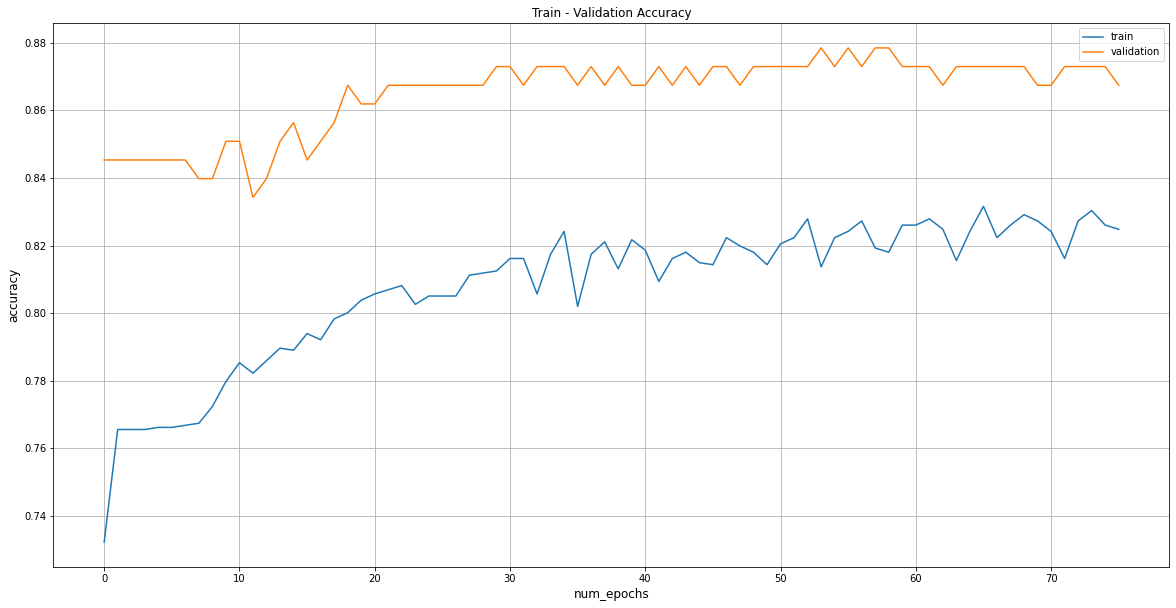

7/7 [==============================] - 5s 658ms/step - loss: 0.3906 - accuracy: 0.8150
Accuracy: 0.8149999976158142


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 10...
Epoch 1/100
51/51 [==============================] - 65s 1s/step - loss: 0.6009 - accuracy: 0.7446 - val_loss: 0.4698 - val_accuracy: 0.8564
Epoch 2/100
51/51 [==============================] - 47s 930ms/step - loss: 0.5517 - accuracy: 0.7668 - val_loss: 0.4390 - val_accuracy: 0.8564
Epoch 3/100
51/51 [==============================] - 47s 929ms/step - loss: 0.5285 - accuracy: 0.7674 - val_loss: 0.4293 - val_accuracy: 0.8564
Epoch 4/100
51/51 [==============================] - 47s 928ms/step - loss: 0.5110 - accuracy: 0.7680 - val_loss: 0.4154 - val_accuracy: 0.8564
Epoch 5/100
51/51 [==============================] - 47s 930ms/step - loss: 0.4924 - accuracy: 0.7680 - val_loss: 0.4055 - val_accuracy: 0.8564
Epoch 6/100
51/51 [==============================] - 47s 928ms/step - loss: 0.4778 - accuracy: 0.7687 - val_loss: 0.3947 - val_accuracy: 0.8508
Epoch 7/100
51/51 [==============================] - 47s 928ms/step - loss: 0.4657 - accuracy: 0.7736 - val_loss: 

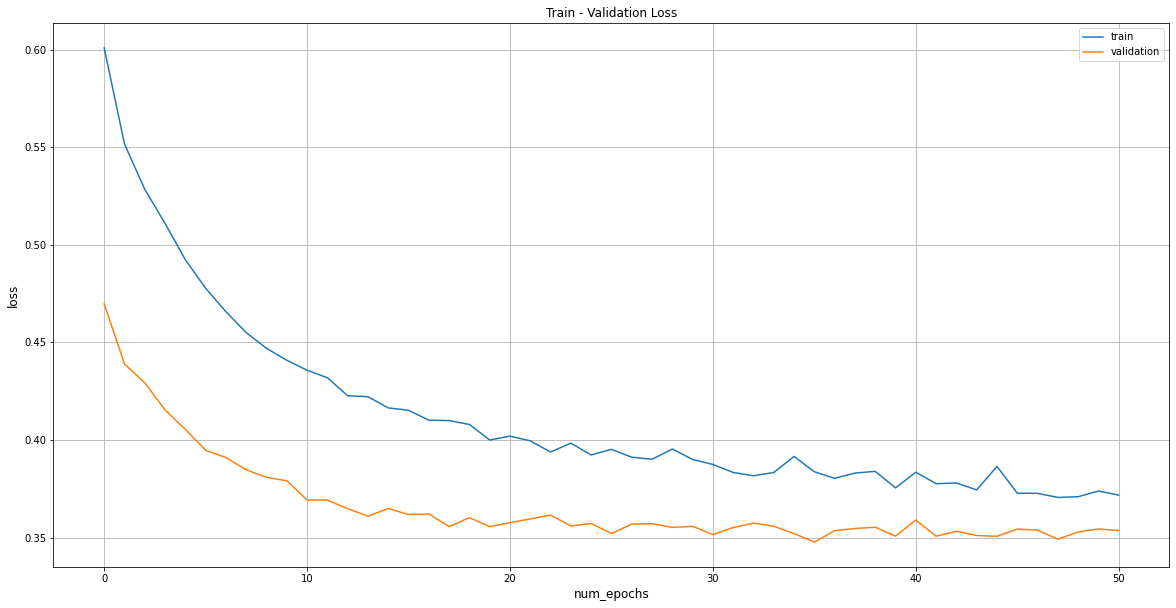

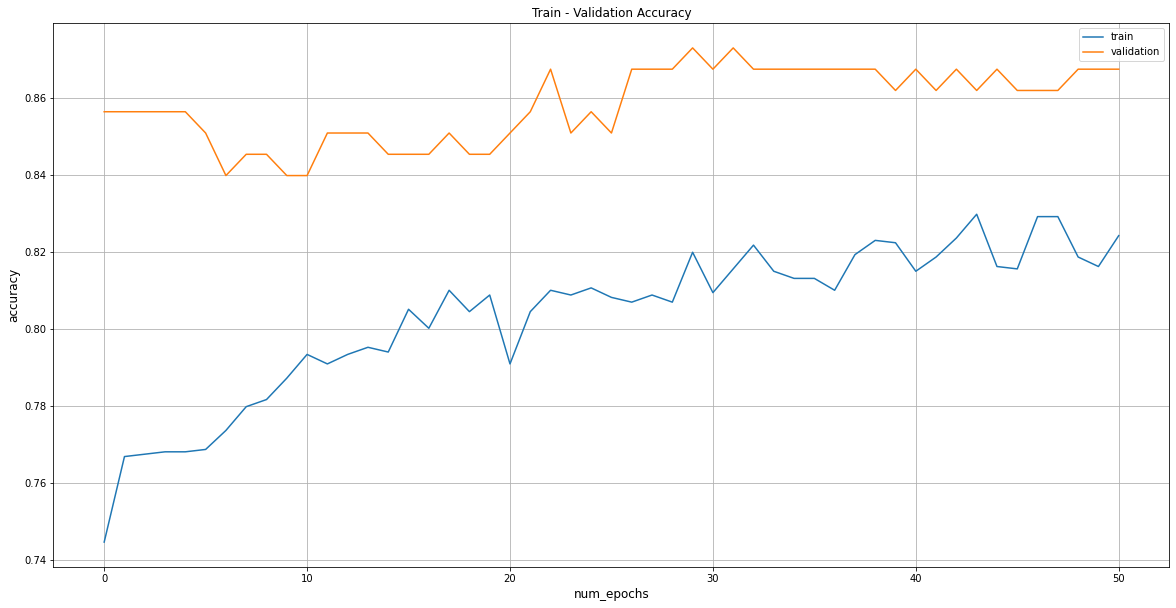

7/7 [==============================] - 5s 658ms/step - loss: 0.3986 - accuracy: 0.8050
Accuracy: 0.8050000071525574


accuracy    0.805216
dtype: float64

In [40]:
N_EPOCAS = 100
kfold = KFold(n_splits=10, shuffle=True)
acc = []
fold = 1
directory_checkpoint = "tfm/checkpoints/impacto_tag_s_n/"
for train, test in kfold.split(dataset_labels.body_no_entities):
    
    fold_train_x = dataset_labels.body_no_entities.values[train]
    textos_train = tokenizer(fold_train_x.tolist(), padding="max_length", truncation=True, return_tensors="tf")
     
    fold_train_y = dataset_labels.impacto_tag_s_n.values[train]
            
    model_checkpoint_callback = ModelCheckpoint(
        filepath=f'{directory_checkpoint}/fold_{fold}',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')
    
    # Para cada Fold se entrena de nuevo
    model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels=N_LABELS)
    model.layers[0].trainable=False
    model.layers[-1].activation=tf.keras.activations.softmax
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    print(f"Starting with Fold {fold}...")

    hist = model.fit(
        textos_train.data,
        fold_train_y,
        validation_split=0.1,
        epochs=N_EPOCAS,
        callbacks=[model_checkpoint_callback, early_stopping]
        )
    
    fold_test_x = dataset_labels.body_no_entities.values[test]
    textos_test = tokenizer(fold_test_x.tolist(), padding="max_length", truncation=True, return_tensors="tf")
    
    fold_test_y = dataset_labels.impacto_tag_s_n.values[test]

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Loss")
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Accuracy")
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    model.load_weights(f'{directory_checkpoint}/fold_{fold}')
    i_acc  = model.evaluate(textos_test.data, fold_test_y)
    print("Accuracy:", i_acc[1])
    acc.append(i_acc[1])
    
    fold += 1
result = pd.DataFrame({'accuracy':acc})
result.mean()

In [41]:
result

,accuracy
0,0.796020
1,0.771144
2,0.805000
3,0.820000
4,0.815000
5,0.810000
6,0.790000
7,0.825000
8,0.815000
9,0.805000


In [42]:
result.mean()

accuracy    0.805216
dtype: float64